# reaching_go_spout_bar_nov22

Quick analysis of instrumental reaching

additional package depedencies: seaborn, papermill

In [1]:
# allow for automatic reloading of classes and function when updating the code
%load_ext autoreload
%autoreload 2 

# Import Session and Experiment class with helper functions
from trialexp.process.data_import import *
from trialexp.process.pycontrol.utils import *
import seaborn as sns


        if you want to export datasets to perform Maching Learning tasks.
        To solve, type pip install sktime in your environment


### Load files


Specify the pycontrol file you want to load

In [13]:
# Only analyze an experimental session

pycontrol_dir = 'Z:\\Teris\\ASAP\\pycontrol\\reaching_go_spout_bar_nov22\\'
filename = 'kms064-2023-02-07-102029'
smrx_output_dir = 'Z:\\Teris\\ASAP\\pycontrol\\reaching_go_spout_bar_nov22\\processed\\'

# pycontrol_dir = 'Z:\\Julien\\Data\\head-fixed\\pycontrol\\reaching_go_spout_bar_nov22\\'
# filename = 'kms063-2023-02-10-152938'


### Parameters

In [3]:
# the state and event name that used to separate behavior into trials
trigger = ('hold_for_water','state_change')

# state and event name that used to indicate a successful trial
success = ('busy_win', 'US_delay_timer')

# state and event name that indicate a spout touch
spout_touch = ('waiting_for_spout', 'spout')

### Analyze events and state

In [4]:
#Create experiment object
exp_cohort = Experiment(pycontrol_dir+filename+'.txt', update = True) #TODO
session = exp_cohort.sessions[0]

# Parse event data
df_events = parse_events(session)

# separate into trials
df_events = add_trial_number(df_events, trigger)
df_events.time = df_events.time /1000 # convert time to s
df_events

,state,event_name,time,trial_number
1,break_after_trial,state_change,0.000,0
2,break_after_trial,CS_offset_timer,2.000,0
4,waiting_for_bar,state_change,6.643,0
5,waiting_for_bar,spout,8.878,0
6,waiting_for_bar,spout_off,8.921,0
...,...,...,...,...
6125,waiting_for_spout,"Print@T:2390858, this trial > X, type:spout, 0...",2396.860,194
6126,break_after_trial,state_change,2396.861,194
6127,break_after_trial,block_timer,2400.000,194
6128,break_after_trial,Print@Finished,2400.000,194


## Analyze the first spout time

In [5]:
#Find first spout time
spouts = df_events[(df_events.state==spout_touch[0]) & (df_events.event_name ==spout_touch[1])].copy()
df_first_spout = spouts.loc[spouts.groupby('trial_number').time.idxmin()]
df_first_spout = df_first_spout.set_index('trial_number')

# find the trial start time
df_trial_start = df_events[(df_events.state==trigger[0]) & (df_events.event_name == trigger[1])].copy()
df_trial_start = df_trial_start.set_index('trial_number')


#calculate the time between the start of trial and first spout touch
df_spout_time = (df_first_spout.time - df_trial_start.time)
df_trial_start['time_first_spout'] = df_spout_time


# Analyze rewards

In [6]:
df_reward = df_events[(df_events.state ==success[0]) & (df_events.event_name == success[1])]
df_reward_num = df_reward.groupby('trial_number').event_name.count()
df_trial_start['num_rewards'] = df_reward_num

## Plotting

In [7]:
df2plot = df_trial_start.reset_index()
df2plot['trial_number'] = df2plot['trial_number'].astype(str) # hack to force it into categorical variable
df2plot

height = len(df2plot)*0.2
fig,ax = plt.subplots(1,2,figsize=(8,height))

sns.barplot( y='trial_number', x='time_first_spout', data=df2plot, ax=ax[0])
ax[0].set(xlabel='Time (s)',title='Time for first spout');

plt.figure(figsize=(8,12))
sns.barplot(y='trial_number', x='num_rewards', data=df2plot, ax = ax[1])
ax[1].set(title='Reward triggered in each trial');

### Summary statistics

In [8]:
print(f'Total reward: {df_trial_start.num_rewards.sum()}')
print(f'Total trials: {df_events.iloc[-1].trial_number}')

#Calculate overall success rate
success_rate = df_trial_start.time_first_spout.notna().mean()
print(f'Success rate: {success_rate}')

#average reward recieved per trial
average_reward = df_trial_start.num_rewards.sum()/df_events.iloc[-1].trial_number
print(f'Average reward per trial: {average_reward}')

#average time to first spout in waiting_for_spout
print(f'Average first spout time {df_trial_start.time_first_spout.mean():.2f}s')

Total reward: 193.0
Total trials: 194
Success rate: 0.5051546391752577
Average reward per trial: 0.9948453608247423
Average first spout time 1.04s


# Event plots

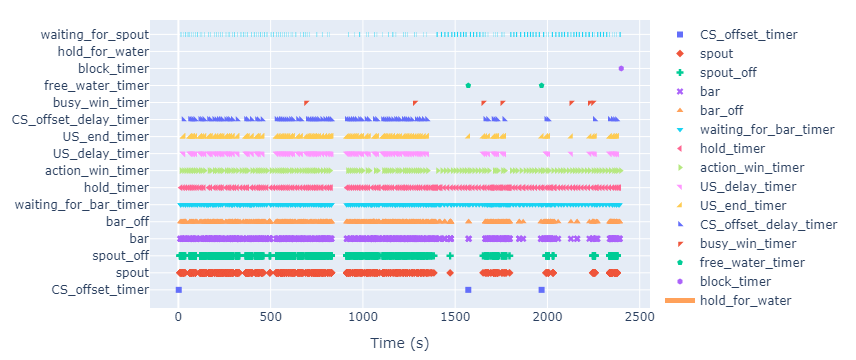

saved Z:\Teris\ASAP\pycontrol\reaching_go_spout_bar_nov22\processed\kms064-2023-02-07-102029.smrx


In [15]:

# state_def = [{'name': 'hold_for_water', 
#                   'onset': 'hold_for_water', 'offset': 'waiting_for_spout'},
#             {'name': 'waiting_for_spout', 
#                  'onset': 'waiting_for_spout', 'offset': 'busy_win'},
#             {'name': 'busy_win', 
#                  'onset': 'busy_win', 'offset': 'break_after_water'},
#             {'name': 'break_after_water', 
#                  'onset': 'break_after_water',    'offset': 'waiting_for_bar'},
#             {'name': 'break_after_no_water', 
#                  'onset': 'break_after_no_water', 'offset': 'waiting_for_bar'}]

state_def = [
            {'name': 'hold_for_water', 
                 'onset': 'hold_for_water', 'offset': 'waiting_for_spout'},
            {'name': 'waiting_for_spout', 
                 'onset': 'waiting_for_spout', 'offset': 'break_after_trial'}]

df2plot = df_events[~df_events.event_name.str.contains('Print@') ]# remove all print statement

keys = df2plot.event_name.unique()
keys = keys[keys!='state_change']

plot_session(df2plot, keys, state_def, export_smrx=True, 
             smrx_filename=smrx_output_dir +f'{filename}.smrx',verbose=False)